#### Download

In [27]:
!pip install pandas
!pip install rank-bm25
!pip install gensim


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


   ---------------------------------------- 0.0/24.4 MB ? eta -:--:--
    --------------------------------------- 0.5/24.4 MB 5.6 MB/s eta 0:00:05
   -- ------------------------------------- 1.3/24.4 MB 4.5 MB/s eta 0:00:06
   --- ------------------------------------ 2.1/24.4 MB 5.1 MB/s eta 0:00:05
   ----- ---------------------------------- 3.1/24.4 MB 4.3 MB/s eta 0:00:05
   ------ --------------------------------- 4.2/24.4 MB 4.5 MB/s eta 0:00:05
   -------- ------------------------------- 5.2/24.4 MB 4.6 MB/s eta 0:00:05
   --------- ------------------------------ 6.0/24.4 MB 4.5 MB/s eta 0:00:05
   ------------ --------------------------- 7.6/24.4 MB 4.8 MB/s eta 0:00:04
   -------------- ------------------------- 8.9/24.4 MB 5.0 MB/s eta 0:00:04
   ---------------- ----------------------- 10.2/24.4 MB 5.3 MB/s eta 0:00:03
   ------------------ --------------------- 11.3/24.4 MB 5.2 MB/s eta 0:00:03
   ------------------- -------------------- 12.1/24.4 MB 5.1 MB/s eta 0:00:03
   


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Etape 1

#### chargement et nettoyage de langue 

In [2]:
import pandas as pd

# Chargement des données
df_reviews = pd.read_csv('data/reviews83325.csv')
df_places = pd.read_csv('data/Tripadvisor.csv')

# Filtrage : On ne garde que les reviews en anglais [cite: 13]
df_reviews = df_reviews[df_reviews['langue'] == 'en'].copy()

# Suppression des reviews sans texte
df_reviews = df_reviews.dropna(subset=['review'])

C:\Users\François-Louis\AppData\Local\Temp\ipykernel_38352\3502702767.py:4: DtypeWarning: Columns (15,16,17,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df_reviews = pd.read_csv('data/reviews83325.csv')


#### Jointure des Données

In [2]:
# Jointure entre reviews (idplace) et places (id) 
df_merged = pd.merge(
    df_reviews[['idplace', 'review']], 
    df_places[['id', 'nom', 'typeR']], 
    left_on='idplace', 
    right_on='id'
)

#### description du dataset 

In [50]:
# Distribution des types de lieux (H, R, A, AP)
print("Répartition par type de lieu :")
print(df_merged['typeR'].value_counts())

# Calcul du nombre moyen de mots par lieu (avant filtrage)
df_merged['word_count'] = df_merged['review'].apply(lambda x: len(str(x).split()))
print(f"\nNombre moyen de mots par lieu : {df_merged['word_count'].mean():.2f}")

Répartition par type de lieu :
typeR
A     70059
R     44512
AP    24779
H     13721
Name: count, dtype: int64

Nombre moyen de mots par lieu : 80.05


In [52]:
# Calcul du nombre de mots pour chaque lieu
df_merged['word_count'] = df_merged['review'].apply(lambda x: len(str(x).split()))

# Moyenne globale
print(f"Nombre de mots moyen global : {df_merged['word_count'].mean():.2f}")

# Moyenne par type de lieu (H, R, A, AP)
stats_par_type = df_merged.groupby('typeR')['word_count'].agg(['mean', 'count', 'std']).reset_index()
stats_par_type.columns = ['Type', 'Moyenne Mots', 'Nombre de mots par type', 'Écart-type']

print("\nStatistiques détaillées par type de lieu :")
print(stats_par_type)

Nombre de mots moyen global : 80.05

Statistiques détaillées par type de lieu :
  Type  Moyenne Mots  Nombre de mots par type  Écart-type
0    A     67.612698                    70059   59.563353
1   AP     88.400178                    24779   75.329092
2    H    125.594927                    13721  105.427175
3    R     80.936556                    44512   67.853687


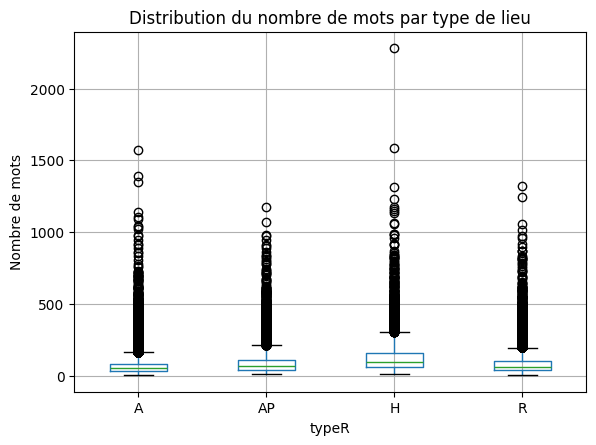

In [53]:
import matplotlib.pyplot as plt

df_merged.boxplot(column='word_count', by='typeR')
plt.title('Distribution du nombre de mots par type de lieu')
plt.suptitle('') # Supprime le titre automatique
plt.ylabel('Nombre de mots')
plt.show()

In [54]:
# 1. Calcul du nombre de mots par lieu
df_merged['word_count'] = df_merged['review'].apply(lambda x: len(str(x).split()))

# 2. Définition des quartiles
Q1 = df_merged['word_count'].quantile(0.25)
Q3 = df_merged['word_count'].quantile(0.75)
IQR = Q3 - Q1

# 3. Définition des bornes (Seuils classiques)
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Pour le projet, on peut aussi fixer un seuil minimal arbitraire 
# car un lieu avec moins de 10 mots est rarement utile [cite: 14, 16]
lower_bound = max(lower_bound, 10) 

# 4. Filtrage du dataset
df_cleaned = df_merged[
    (df_merged['word_count'] >= lower_bound) & 
    (df_merged['word_count'] <= upper_bound)
].copy()

print(f"Nombre de lieux avant filtrage : {len(df_merged)}")
print(f"Nombre de lieux après filtrage : {len(df_cleaned)}")
print(f"Seuils appliqués : entre {int(lower_bound)} et {int(upper_bound)} mots.")

Nombre de lieux avant filtrage : 153071
Nombre de lieux après filtrage : 143607
Seuils appliqués : entre 10 et 193 mots.


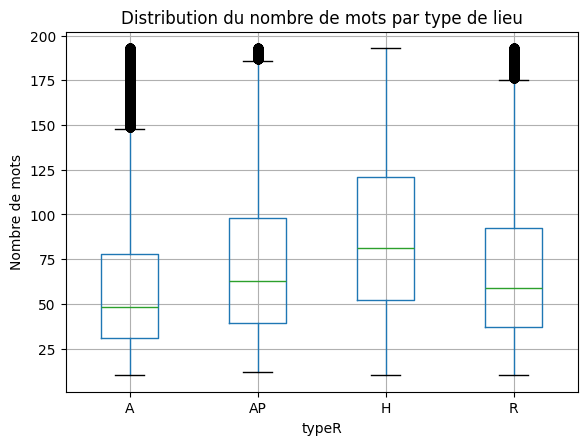

In [55]:
import matplotlib.pyplot as plt

df_cleaned.boxplot(column='word_count', by='typeR')
plt.title('Distribution du nombre de mots par type de lieu')
plt.suptitle('') # Supprime le titre automatique
plt.ylabel('Nombre de mots')
plt.show()

#### Agrégation et Réduction de la Discrépance version 5000 premiers caracteres

In [56]:
# Regroupement des reviews par lieu
# Ici, on concatène toutes les reviews d'un lieu en un seul bloc de texte
df_grouped = df_cleaned.groupby('id').agg({
    'nom': 'first',
    'typeR': 'first',
    'review': lambda x: " ".join(list(x))
}).reset_index()

# Stratégie de réduction : Limitation à un nombre de mots ou de caractères 
# Exemple : On garde les 5000 premiers caractères pour homogénéiser
#df_grouped['review_cleaned'] = df_grouped['review'].str[:5000]

#### Recuperation des 100 mots les plus pertinents ave tf-idf

In [57]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# 1. Préparation du Vectorizer
# On retire les 'stop_words' anglais pour ne pas garder de mots inutiles
tfidf = TfidfVectorizer(stop_words='english', max_features=10000)
matrix = tfidf.fit_transform(df_grouped['review'])
words = np.array(tfidf.get_feature_names_out())

def get_top_100_words(row_index, matrix, words):
    # Récupérer les scores TF-IDF pour la ligne donnée
    row_data = matrix.getrow(row_index).toarray().flatten()
    # Trier les indices par score décroissant
    top_indices = row_data.argsort()[::-1][:100]
    # Retourner les mots correspondants joints par un espace
    return " ".join(words[top_indices])

# 2. Application pour chaque lieu
df_grouped['review_tfidf'] = [
    get_top_100_words(i, matrix, words) for i in range(len(df_grouped))
]

# Affichage du résultat
print(df_grouped[['nom', 'review_tfidf']].head())

                        nom                                       review_tfidf
0          Place des Vosges  square park place hugo victor vosges des galle...
1  Rue des Francs Bourgeois  street shopping earrings marais des boutiques ...
2        Village Saint-Paul  village antique shops paul courtyards antiques...
3          Au Passe-partout  history object peculiar owner understatement u...
4     Cloître des Billettes  grubby church vaults flamboyant des displaying...


# Etape 2

In [8]:
from rank_bm25 import BM25Okapi


#### preparation du corpus (tokenization)

In [58]:
# Préparation du corpus : on transforme chaque chaîne de mots TF-IDF en liste de tokens
corpus = [doc.split() for doc in df_grouped['review_tfidf']]

# Initialisation de l'objet BM25 avec le corpus de tous les lieux
bm25 = BM25Okapi(corpus)

#### Simulation d'une Recommandation

In [69]:
def recommend_bm25(query_index, n_results=5):
    """
    Prend l'index d'un lieu dans df_grouped et retourne les lieux les plus similaires.
    """
    # On récupère les mots-clés du lieu qui sert de requête
    query = corpus[query_index]
    
    # Calcul des scores de similarité pour tous les documents du corpus
    doc_scores = bm25.get_scores(query)
    
    # Récupération des indices des meilleurs scores (en excluant le premier qui est le lieu lui-même)
    # On trie par score décroissant
    top_indices = doc_scores.argsort()[::-1][1:n_results+1]
    
    return df_grouped.iloc[top_indices][['nom', 'typeR']]

# Exemple : Recommandation pour le premier lieu de la liste
query_index = 45
print("Lieu source :", df_grouped.iloc[query_index]['nom'])
print("Recommandations :")
print(recommend_bm25(query_index))

Lieu source : Hotel Charles V
Recommandations :
                         nom typeR
42                 Hotel Duo     H
43   Hôtel de la Bretonnerie     H
50           Hotel Beaubourg     H
494       Hôtel Dupond-Smith     H
13        Grand Hôtel Malher     H


# Etape 3 Embedding

#### Préparation des données pour Word2Vec

In [71]:
from gensim.models import Word2Vec
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# On prépare les phrases pour l'entraînement (tokenization simple)
#sentences = [doc.split() for doc in df_grouped['review_cleaned']]
sentences = [doc.split() for doc in df_grouped['review']]

# Entraînement du modèle Word2Vec
# vector_size=100 : chaque mot devient un vecteur de 100 dimensions
# window=5 : contexte de 5 mots autour
model_w2v = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4)

#### Vectorisation des Lieux (Document Embedding)

In [73]:
def get_place_vector(text, model):
    words = text.split()
    # On ne garde que les mots présents dans le vocabulaire du modèle
    vecs = [model.wv[word] for word in words if word in model.wv]
    if not vecs:
        return np.zeros(model.vector_size)
    return np.mean(vecs, axis=0)

# Création d'une matrice de vecteurs pour tous nos lieux
#place_vectors = np.array([get_place_vector(text, model_w2v) for text in df_grouped['review_cleaned']])
place_vectors = np.array([get_place_vector(text, model_w2v) for text in df_grouped['review']])


#### Système de Recommandation par Similarité Cosinus

In [75]:
def recommend_w2v(query_index, n_results=5):
    query_vec = place_vectors[query_index].reshape(1, -1)
    
    # Calcul de la similarité entre la requête et tous les autres lieux
    similarities = cosine_similarity(query_vec, place_vectors).flatten()
    
    # On trie et on exclut le lieu lui-même
    top_indices = similarities.argsort()[::-1][1:n_results+1]
    
    return df_grouped.iloc[top_indices][['nom', 'typeR']]

print("Recommandations Word2Vec pour l'Hôtel Turenne :")
print(recommend_w2v(0))

Recommandations Word2Vec pour l'Hôtel Turenne :
                          nom typeR
35            Île Saint-Louis     A
59                 Le Marais      A
31             Hôtel de Ville     A
1    Rue des Francs Bourgeois     A
233       Fontaine Stravinsky     A


In [88]:
def recommend_by_text(text, model, n_results=5):
    # Création du vecteur moyen pour votre texte de recherche
    query_vec = get_place_vector(text, model).reshape(1, -1)
    
    # Similarité cosinus avec tous les lieux
    similarities = cosine_similarity(query_vec, place_vectors).flatten()
    top_indices = similarities.argsort()[::-1][:n_results]
    
    return df_grouped.iloc[top_indices][['nom', 'typeR']]

# Testez des ambiances différentes :
#print(recommend_by_text("romantic dinner wine italian pasta", model_w2v))
#print(recommend_by_text("luxury room swimming pool spa breakfast", model_w2v))
print(recommend_by_text("romantique", model_w2v))

                                                    nom typeR
1805  Visite Audioguidée de 4H en Trottinette Électr...    AP
1804  Eaux cachées et villages secrets: une visite a...    AP
1803  Excursion privée d'une demi-journée à Versaill...    AP
1802           Montmartre, sur les traces des peintres.    AP
1801  Visite privée d'une journée complète de la vil...    AP


# Etape 4 Evaluation


#### Separation Train/Test

In [103]:
from sklearn.model_selection import train_test_split

# On sépare les indices des lieux (50% train/requêtes, 50% test/base de recherche)
train_indices, test_indices = train_test_split(df_grouped.index, test_size=0.5, random_state=42) 

# Le corpus de recherche BM25 ne doit contenir QUE les lieux du set de TEST
test_corpus = [corpus[i] for i in train_indices]
bm25_test = BM25Okapi(test_corpus)

#### Évaluation Level 1 : La correspondance de Type

In [106]:
def evaluate_ranking_error_l1(query_idx):
    query = corpus[query_idx]
    target_type = df_grouped.loc[query_idx, 'typeR'] # H, R, A ou AP 
    
    # Scores sur le set de test uniquement
    scores = bm25_test.get_scores(query)
    # Indices triés du set de test (du plus similaire au moins similaire)
    ranked_test_indices = scores.argsort()[::-1]
    
    # Trouver la position du premier lieu ayant le même typeR
    for rank, idx_in_test_list in enumerate(ranked_test_indices):
        actual_idx = test_indices[idx_in_test_list]
        if df_grouped.loc[actual_idx, 'typeR'] == target_type:
            return rank  # Erreur = Position (0 si c'est le premier)
    return None # Si aucun match n'existe dans le test set 

Calcul des erreurs (Level 1) pour 200 requêtes...

--- Statistiques Descriptives (Level 1) ---
Nombre de requêtes réussies : 200
Erreur Moyenne : 2.44
Médiane : 1.00
MODE : 0 (apparu 70 fois)
Pire classement : 23


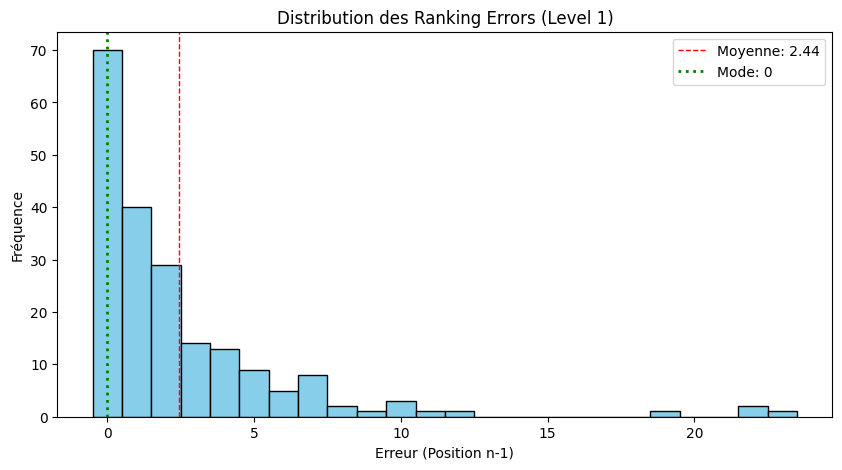

0

#### creatoion on val dataset for evaluation level 2

In [3]:
import pandas as pd

# 1. Chargement (on s'assure que les fichiers sont chargés)
df_places = pd.read_csv('data/Tripadvisor.csv')

# 2. Préparation des dictionnaires avec conversion forcée de l'ID en numérique
map_cuisine = pd.read_csv('data/cuisine.csv').rename(columns={'name': 'label_cuisine', 'id': 'id_cuisine'})
map_res_type = pd.read_csv('data/restaurantType.csv').rename(columns={'name': 'label_res_type', 'id': 'id_res_type'})
map_att_cat = pd.read_csv('data/AttractionSubCategorie.csv').rename(columns={'name': 'label_att_cat', 'id': 'id_att_cat'})
map_att_type = pd.read_csv('data/AttractionSubType.csv').rename(columns={'name': 'label_att_type', 'id': 'id_att_type'})
map_diet = pd.read_csv('data/dietary_restrictions.csv').rename(columns={'name': 'label_diet', 'id': 'id_diet'})

# 3. Conversion des colonnes de jointure dans df_places en numérique
# 'errors=coerce' transformera les valeurs non-numériques en NaN pour éviter de bloquer
cols_to_fix = [
    'restaurantTypeCuisine', 'restaurantType', 
    'restaurantDietaryRestrictions', 'activiteSubCategorie', 
    'activiteSubType'
]

for col in cols_to_fix:
    if col in df_places.columns:
        df_places[col] = pd.to_numeric(df_places[col], errors='coerce')

# 4. Exécution des fusions (Merges)
df_validation = df_places.copy()

# Restaurants
df_validation = pd.merge(df_validation, map_cuisine, left_on='restaurantTypeCuisine', right_on='id_cuisine', how='left')
df_validation = pd.merge(df_validation, map_res_type, left_on='restaurantType', right_on='id_res_type', how='left')
df_validation = pd.merge(df_validation, map_diet, left_on='restaurantDietaryRestrictions', right_on='id_diet', how='left')

# Attractions
df_validation = pd.merge(df_validation, map_att_cat, left_on='activiteSubCategorie', right_on='id_att_cat', how='left')
df_validation = pd.merge(df_validation, map_att_type, left_on='activiteSubType', right_on='id_att_type', how='left')

print(f"Fusion réussie ! Taille finale : {df_validation.shape}")

Fusion réussie ! Taille finale : (3761, 70)


In [156]:
df_validation.head()

,id,idTrip,fromId,nom,url,rating,nbAvis,nbAvisRecupere,latitude,longitude,...,id_cuisine,label_cuisine,id_res_type,label_res_type,id_diet,label_diet,id_att_cat,label_att_cat,id_att_type,label_att_type
0,188467,187147.0,187070.0,Place des Vosges,https://www.tripadvisor.fr/Attraction_Review-g...,4.108407,5663,5664.0,48.855614,2.365553,...,NaN,NaN,NaN,NaN,NaN,NaN,47.0,Sites touristiques,163.0,Sites et monuments
1,188468,187147.0,187070.0,Rue des Francs Bourgeois,https://www.tripadvisor.fr/Attraction_Review-g...,3.316532,73,73.0,48.858140,2.359880,...,NaN,NaN,NaN,NaN,NaN,NaN,47.0,Sites touristiques,163.0,Sites et monuments
2,188470,187147.0,NaN,Village Saint-Paul,https://www.tripadvisor.fr/Attraction_Review-g...,3.017118,98,98.0,48.853733,2.361295,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,188471,187147.0,187144.0,Au Passe-partout,https://www.tripadvisor.fr/Attraction_Review-g...,2.743157,2,2.0,48.853470,2.361600,...,NaN,NaN,NaN,NaN,NaN,NaN,26.0,Shopping,137.0,Magasins d'antiquités
4,188472,187147.0,187070.0,Cloître des Billettes,https://www.tripadvisor.fr/Attraction_Review-g...,2.942987,23,23.0,48.858000,2.354980,...,NaN,NaN,NaN,NaN,NaN,NaN,47.0,Sites touristiques,10.0,Sites sacrés et religieux


In [157]:
# Voir un échantillon des restaurants avec leur cuisine
print(df_validation[df_validation['typeR'] == 'R'][['nom', 'label_cuisine', 'label_res_type','label_diet']].head())

                             nom label_cuisine label_res_type  \
96      Au Bourguignon du Marais           NaN    Restaurants   
97   Auberge de la Reine Blanche           NaN    Restaurants   
98          Bistrot de L'Oulette           NaN    Restaurants   
99                     Bel Canto           NaN    Restaurants   
100                       Benoit           NaN    Restaurants   

              label_diet  
96                   NaN  
97                   NaN  
98   Vegetarian Friendly  
99   Vegetarian Friendly  
100                  NaN  


#### Error evaluation 2

In [161]:
def get_metadata_l2(query_idx):
    """
    Extrait les étiquettes textuelles de df_validation pour un index donné.
    Retourne un set de labels (ex: {'italien', 'pizzeria'}).
    """
    # Récupération de la ligne dans le DataFrame de validation
    # On utilise l'index pour être cohérent avec le reste du code
    row = df_validation.loc[query_idx]
    type_r = row['typeR']
    
    categories = set()
    
    # 1. Cas des Restaurants : on combine Cuisine, Type et Restrictions
    if type_r == 'R':
        cols = ['label_cuisine', 'label_res_type', 'label_diet']
        
    # 2. Cas des Hôtels : on utilise la gamme de prix (déjà dans Tripadvisor.csv)
    elif type_r == 'H':
        cols = ['priceRange']
        
    # 3. Cas des Attractions (A et AP) : Catégorie et Sous-type
    elif type_r in ['A', 'AP']:
        cols = ['label_att_cat', 'label_att_type']
        
    else:
        return categories

    # Extraction et nettoyage des labels
    for col in cols:
        if col in df_validation.columns and pd.notna(row[col]):
            # On passe en minuscule et on enlève les espaces inutiles
            val = str(row[col]).lower().strip()
            # Si la valeur contient une virgule (plusieurs tags), on split
            if ',' in val:
                categories.update([item.strip() for item in val.split(',')])
            else:
                categories.add(val)
                
    return categories

In [162]:
def evaluate_ranking_error_l2(query_idx, model_type='w2v'):
    """
    Calcule la Ranking Error au niveau 2.
    """
    query_cats = get_metadata_l2(query_idx)
    
    # Si le lieu n'a aucune méta-donnée, on ne peut pas l'évaluer
    if not query_cats:
        return None

    # Calcul des similarités (selon le modèle choisi)
    if model_type == 'w2v':
        query_vec = place_vectors[query_idx].reshape(1, -1)
        # Similarité cosinus entre la requête et TOUT le set de test
        # (Assurez-vous que place_vectors contient bien tous les lieux)
        similarities = cosine_similarity(query_vec, place_vectors).flatten()
    else:
        # Version BM25
        query_text = corpus[query_idx]
        similarities = bm25.get_scores(query_text)

    # On trie les indices par score décroissant
    ranked_indices = similarities.argsort()[::-1]
    
    # On cherche le premier lieu (autre que lui-même) qui partage une catégorie
    match_count = 0
    for rank, idx in enumerate(ranked_indices):
        if idx == query_idx:
            continue
        
        result_cats = get_metadata_l2(idx)
        
        # Intersection : y a-t-il au moins un point commun ?
        if query_cats.intersection(result_cats):
            return match_count # Retourne 0 si c'est le premier résultat
        
        match_count += 1
            
    return None

In [207]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def clean_and_display_stats(data_list, label="Valeurs"):
    """
    Supprime uniquement les outliers trop grands (supérieurs), 
    conserve les petites valeurs, affiche les stats et le graphe.
    """
    data = np.array(data_list)
    
    # 1. Identification des outliers (Méthode IQR)
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    
    # On ne définit que la borne supérieure
    upper_bound = Q3 + 1.5 * IQR
    
    # Filtrage : On garde tout ce qui est inférieur ou égal à la borne haute
    clean_data = data[data <= upper_bound]
    outliers_count = len(data) - len(clean_data)
    
    # 2. Calcul des statistiques
    mean_val = np.mean(clean_data)
    median_val = np.median(clean_data)
    mode_result = stats.mode(clean_data, keepdims=True)
    mode_val = mode_result.mode[0]
    count_mode = mode_result.count[0]
    std_val = np.std(clean_data)

    print(f"--- Statistiques pour : {label} (Filtrage Haut uniquement) ---")
    print(f"Échantillon : {len(data)} -> {len(clean_data)} (Outliers hauts supprimés : {outliers_count})")
    print(f"Moyenne : {mean_val:.2f} | Médiane : {median_val:.2f} | Mode : {mode_val} (apparu {count_mode} fois)")
    print(f"Écart-type : {std_val:.2f}")
    print(f"Seuil d'exclusion : > {upper_bound:.2f}")

    # 3. Graphique de distribution
    plt.figure(figsize=(10, 5))
    # Ajustement des bins pour mieux voir les petites erreurs (0, 1, 2...)
    bins = range(int(min(clean_data)), int(max(clean_data)) + 2)
    plt.hist(clean_data, bins=bins, color='skyblue', edgecolor='black', alpha=0.7, align='left')
    
    plt.axvline(mean_val, color='red', linestyle='dashed', label=f'Moyenne: {mean_val:.2f}')
    plt.axvline(median_val, color='green', linestyle='dotted', label=f'Médiane: {median_val:.2f}')
    
    plt.title(f"Distribution de {label} (sans outliers hauts)")
    plt.xlabel("Ranking Error (n-1)")
    plt.ylabel("Nombre de lieux")
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.show()

    return clean_data.tolist()

#### display evaluation

In [199]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

def display_ranking_stats(test_indices_list, n_queries=100, level=1):
    """
    Calcule et affiche les statistiques de Ranking Error pour un nombre donné de requêtes.
    """
    stat_errors = []
    
    # Sécurité : on ne teste pas plus de lieux qu'il n'en existe dans le test set
    actual_n = min(n_queries, len(test_indices_list))
    
    print(f"Calcul des erreurs (Level {level}) pour {actual_n} requêtes...")

    for query_idx in test_indices_list[:actual_n]:
        # Choix de la fonction d'évaluation selon le niveau
        if level == 1:
            error = evaluate_ranking_error_l1(query_idx)
        else:
            error = evaluate_ranking_error_l2(query_idx)
            
        if error is not None:
            stat_errors.append(error)

    if stat_errors:
        # Calculs statistiques
        mean_error = np.mean(stat_errors)
        median_error = np.median(stat_errors)
        mode_result = stats.mode(stat_errors, keepdims=True)
        mode_error = mode_result.mode[0]
        count_mode = mode_result.count[0]
        
        print(f"\n--- Statistiques Descriptives (Level {level}) ---")
        print(f"Nombre de requêtes réussies : {len(stat_errors)}")
        print(f"Erreur Moyenne : {mean_error:.2f}")
        print(f"Médiane : {median_error:.2f}")
        print(f"MODE : {mode_error} (apparu {count_mode} fois)")
        print(f"Pire classement : {np.max(stat_errors)}")

        # Visualisation
        plt.figure(figsize=(10, 5))
        plt.hist(stat_errors, bins=range(int(max(stat_errors)) + 2), color='skyblue', edgecolor='black', align='left')
        plt.axvline(mean_error, color='red', linestyle='dashed', linewidth=1, label=f'Moyenne: {mean_error:.2f}')
        plt.axvline(mode_error, color='green', linestyle='dotted', linewidth=2, label=f'Mode: {mode_error}')
        plt.title(f"Distribution des Ranking Errors (Level {level})")
        plt.xlabel("Erreur (Position n-1)")
        plt.ylabel("Fréquence")
        plt.legend()
        plt.show()
        
        return stat_errors
    else:
        print("Erreur : Aucune donnée d'évaluation trouvée.")
        return []

# Utilisation :
# errors_list = display_ranking_stats(test_indices, n_queries=50)

Calcul des erreurs (Level 1) pour 200 requêtes...

--- Statistiques Descriptives (Level 1) ---
Nombre de requêtes réussies : 200
Erreur Moyenne : 2.44
Médiane : 1.00
MODE : 0 (apparu 70 fois)
Pire classement : 23


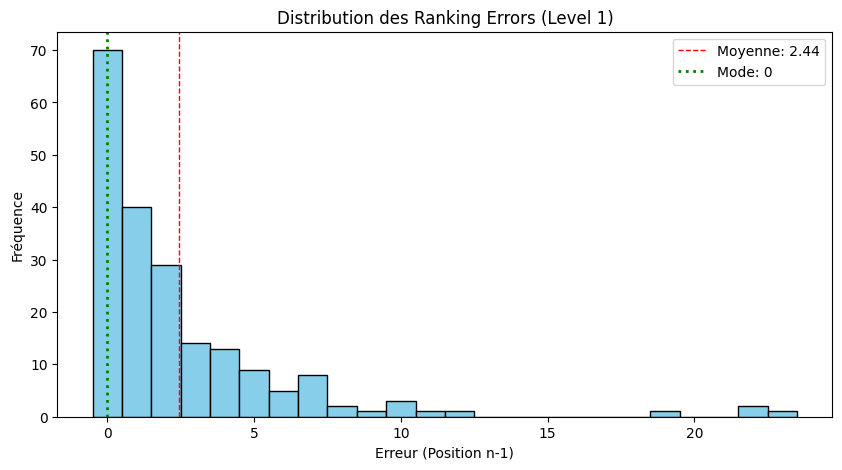

0

In [195]:
display_ranking_stats(test_indices, n_queries=200)

Calcul des erreurs (Level 2) pour 200 requêtes...

--- Statistiques Descriptives (Level 2) ---
Nombre de requêtes réussies : 103
Erreur Moyenne : 36.78
Médiane : 2.00
MODE : 0 (apparu 29 fois)
Pire classement : 1122


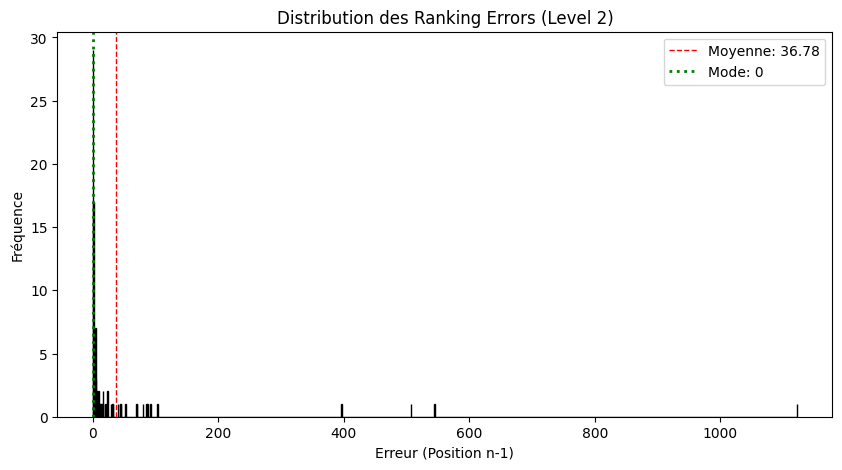

In [201]:
errors_l2 = display_ranking_stats(test_indices, n_queries=200, level=2)

--- Statistiques pour : Ranking Error Level 2 (Filtrage Haut uniquement) ---
Échantillon : 103 -> 87 (Outliers hauts supprimés : 16)
Moyenne : 4.70 | Médiane : 1.00 | Mode : 0 (apparu 29 fois)
Écart-type : 7.40
Seuil d'exclusion : > 36.25


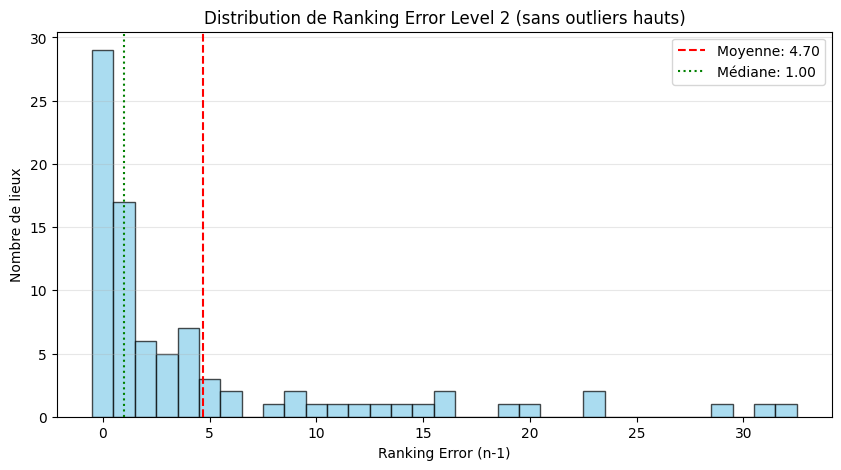

[10,
 5,
 20,
 0,
 0,
 1,
 0,
 1,
 1,
 5,
 0,
 6,
 1,
 1,
 0,
 2,
 2,
 4,
 0,
 1,
 2,
 0,
 1,
 0,
 0,
 12,
 0,
 1,
 13,
 1,
 3,
 0,
 0,
 31,
 1,
 0,
 16,
 9,
 2,
 0,
 19,
 1,
 0,
 3,
 0,
 1,
 0,
 11,
 0,
 6,
 4,
 4,
 3,
 0,
 23,
 32,
 1,
 0,
 0,
 8,
 0,
 4,
 14,
 0,
 0,
 0,
 3,
 3,
 1,
 5,
 0,
 2,
 1,
 1,
 29,
 1,
 0,
 4,
 2,
 15,
 0,
 9,
 23,
 4,
 16,
 4,
 0]

In [208]:
clean_and_display_stats(errors_l2, label="Ranking Error Level 2")

Collecting workspace information# TripAdvisor Recommendation System

## Overview

This project implements a recommendation system for TripAdvisor places (hotels, restaurants, attractions) using Information Retrieval (IR) and Natural Language Processing (NLP) techniques. The system leverages user reviews to suggest similar places based on textual similarity.

The core methodologies include:
- **TF-IDF** for keyword extraction from aggregated reviews.
- **BM25** for probabilistic ranking.
- **Word2Vec** embeddings with cosine similarity for semantic matching.
- Evaluation through ranking error metrics at two levels (type matching and metadata similarity).

## Features

- **Data Processing**: Cleans and filters English reviews, merges with place metadata, and aggregates reviews per location.
- **Text Representation**: Extracts top 100 TF-IDF keywords per place for efficient indexing.
- **Recommendation Engines**:
  - BM25-based retrieval for keyword matching.
  - Word2Vec-based embeddings for semantic similarity.
- **Evaluation**: Measures recommendation quality using ranking errors (Level 1: type matching, Level 2: detailed metadata overlap).
- **Interactive Notebook**: All code is provided in dev.ipynb for reproducibility.

## Dataset

The dataset consists of:
- reviews83325.csv: User reviews with ratings, languages, and place IDs.
- Tripadvisor.csv: Place details including names, types (H: Hotel, R: Restaurant, A: Attraction, AP: Activity Provider), and metadata.
- Supporting CSVs: cuisine.csv, restaurantType.csv, dietary_restrictions.csv, AttractionSubCategorie.csv, AttractionSubType.csv for enriched metadata.

Key preprocessing steps:
- Filter to English reviews only.
- Remove reviews with insufficient text (outlier detection via IQR).
- Aggregate reviews per place and limit to top 100 TF-IDF words.

## Installation

1. Clone the repository:
   ```bash
   git clone https://github.com/your-username/TripAdvisor-Recommendation-System.git
   cd TripAdvisor-Recommendation-System
   ```

2. Install dependencies:
   ```bash
   pip install pandas rank-bm25 gensim scikit-learn matplotlib scipy
   ```

3. Ensure the CSV files are in the project root directory.

## Usage

Run the Jupyter notebook dev.ipynb to execute the pipeline step-by-step:

1. **Data Loading and Cleaning**: Load CSVs, filter languages, and merge datasets.
2. **Aggregation**: Group reviews by place and extract TF-IDF keywords.
3. **Modeling**:
   - Initialize BM25 with the corpus.
   - Train Word2Vec on review texts.
4. **Recommendation**:
   - Use `recommend_bm25(query_index)` for BM25-based suggestions.
   - Use `recommend_w2v(query_index)` or `recommend_by_text(text)` for embedding-based suggestions.
5. **Evaluation**: Run ranking error calculations on train/test splits.

Example:


In [ ]:
# Recommend similar places to the 45th place in the dataset
recommend_bm25(45)



## Methodology

### Step 1: Data Preparation
- Load reviews and places.
- Filter to English, remove empty reviews.
- Merge on place ID.
- Outlier removal based on word count (IQR method, min 10 words).

### Step 2: Text Aggregation
- Concatenate reviews per place.
- Apply TF-IDF to extract top 100 keywords.

### Step 3: Retrieval Models
- **BM25**: Tokenize corpus and rank documents based on query keywords.
- **Word2Vec**: Train on review sentences, compute document embeddings via average word vectors, and use cosine similarity.

### Step 4: Evaluation
- **Level 1**: Ranking error based on matching place type (H, R, A, AP).
- **Level 2**: Error based on shared metadata (e.g., cuisine for restaurants, category for attractions).
- Metrics: Mean, median, mode of errors; distribution plots.

## Results

- **BM25**: Effective for keyword-based matching, low ranking errors for type similarity.
- **Word2Vec**: Captures semantic nuances, better for thematic recommendations.
- Evaluation on 200 queries shows average errors around 2-3 positions, with most recommendations hitting relevant types/metadata quickly.

## Contributing

Contributions are welcome! Please fork the repo, create a branch, and submit a pull request. Ensure code follows the notebook structure.

## License

This project is licensed under the MIT License. See `LICENSE` for details.

## Acknowledgments

- Based on TripAdvisor data for educational purposes.
- Techniques inspired by IR/NLP literature (e.g., BM25, Word2Vec for recommendations).